In [1]:
import pandas as pd
import uproot
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
import numpy as np


In [2]:
#400 amev
fname = "carbon_target_2198_400amev_run_0183_0001"
#fname = "carbon_target_1086_400amev_run_0181_0001"
#fname = "carbon_target_54_400amev_run_0179_0001"
#fname = "empty_target_2198_400amev_run_0187_0001"
#550 amev
#fname = "carbon_target_2198_550amev_run_0103_0001"
#fname = "carbon_target_1086_550amev_run_0101_0001"
#fname = "carbon_target_54_550amev_run_0099_0001"
#fname = "empty_target_2198_550amev_run_0096_0001"
#650 amev
#fname = "carbon_target_2198_650amev_run_0130_0001"
#fname = "carbon_target_1086_650amev_run_0127_0001"
#fname = "carbon_target_54_650amev_run_0126_0001"
#fname = "empty_target_2198_650amev_run_0124_0001"
#800 amev
#fname = "carbon_target_2198_800amev_run_0170_0001"
#fname = "carbon_target_1086_800amev_run_0168_0001"
#fname = "carbon_target_54_800amev_run_0166_0001"
#fname = "empty_target_2198_800amev_run_0173_0001"


#file = uproot.open("/home/tobiasjenegger/some_rootfiles/carbon_target_2198_400amev_run_0183_0001.root")
file = uproot.open("/home/tobiasjenegger/some_rootfiles/"+fname+".root")
#open tree
tree = file["points"] 
df = tree.arrays(library="pd") 
#A LITTLE BIT DANGEROUS,smooth out df['x']
sigma_x = 0.7
#df['x'] = df['x'] + np.random.normal(loc=0, scale=sigma_x, size=len(df))

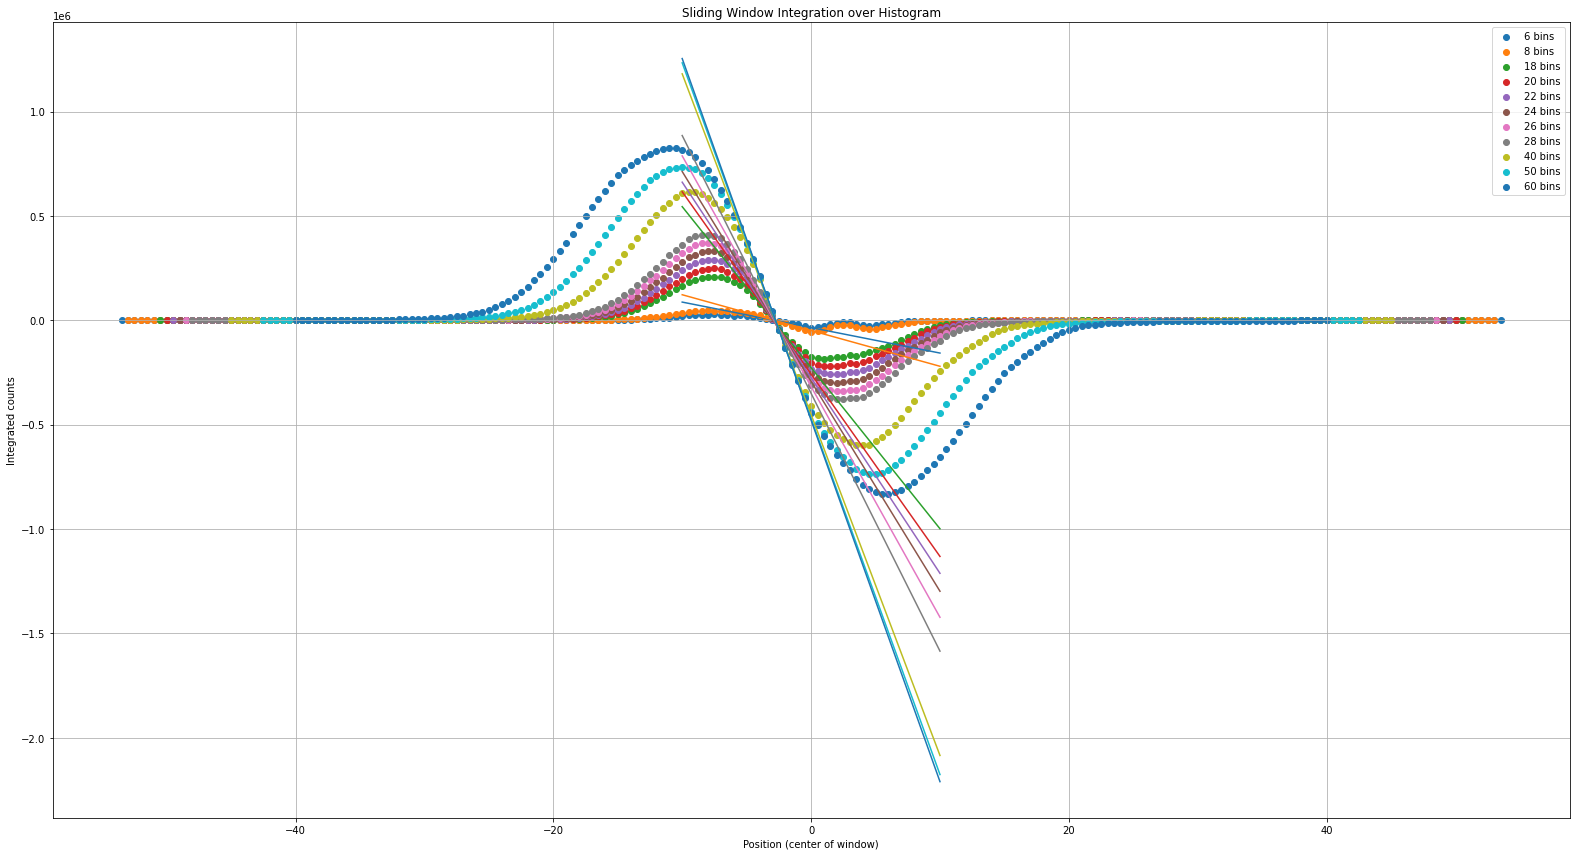

In [3]:
arr_middle_int_points = []
arr_integral_window = []
plt.figure(figsize=(22, 12))

# Create histogram
counts, bin_edges = np.histogram(df["x"], bins=220, range=(-55, 55))

bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bin_edges[1] - bin_edges[0]

# Set window size
#window_size = 20
window_sizes = [6,8,18, 20, 22, 24,26,28,40,50,60]
#window_sizes = [6,8]

for window_size in window_sizes:
    # Integrate over sliding window
    integrals = []
    positions = []

    for i in range(len(counts) - window_size + 1):
        window_counts = counts[i:i+window_size]

        integral = np.sum(window_counts[int(window_size/2):]) - np.sum(window_counts[0:int(window_size/2)])
        integrals.append(integral)
        # Store the center of the window for reference
        center_position = np.mean(bin_centers[i:i+window_size])
        #print("bin centers to consider:\t",bin_centers[i:i+window_size] )
        #print("these center_position", center_position)
        positions.append(center_position)
    plt.scatter(positions, integrals, label=f'{window_size} bins')
    #plt.yscale('log')
    
    #print("WINDOW SIZE:\t",window_size)
    zero_crossings = np.where(np.diff(np.sign(integrals)))[0]
    #print("----------------")
    #print("positions shape:",len(positions))
    #print("bin_centers shape",bin_centers.shape)
    #print("zero_crossings shape",zero_crossings.shape)
    #print("integral shape",len(integrals))
    
    #print("zero crossings")
    #print(zero_crossings)
    #print(integrals[110])
    #print(bin_centers[110])
    #print("and this prints the positions")
    #print(positions[110])
    filtered = zero_crossings[(zero_crossings >=70) & (zero_crossings <= 105)]
    #print(filtered)
    if (filtered.shape[0] > 0):
        #print(filtered[0])
        x_fit = positions[filtered[0]-1:filtered[0]+3]
        y_fit = integrals[filtered[0]-1:filtered[0]+3]
        #print("x-y")
        #print(x_fit)
        #print(y_fit)
        coeffs = np.polyfit(x_fit, y_fit, deg=1)
        m, b = coeffs
        #print(f"Slope (m): {m}")
        #print(f"Intercept (b): {b}")
        
        if m != 0:
            x_at_y0 = -b / m
            #print(f"x where y = 0: {x_at_y0}")
            arr_middle_int_points.append(x_at_y0)
            arr_integral_window.append(window_size)
            fx = np.linspace(-10,10)
            fy = m*fx+b
            plt.plot(fx,fy)
            
        else:
            print("The fit is horizontal (slope = 0), so y never crosses 0.")
        

    

# Finalize plot
plt.xlabel('Position (center of window)')
plt.ylabel('Integrated counts')
plt.title('Sliding Window Integration over Histogram')
#plt.plot(-2, 0, marker='o', color='red', label='Point (-2, 0)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show() 

In [4]:
mean_val_mw1_x = arr_middle_int_points[0] + 0.25 #best: arr_middle_int_points[0] + 0.25
print(mean_val_mw1_x)
df['x_symmetric'] = df['x'].apply(lambda x: 2 * mean_val_mw1_x - x if x > mean_val_mw1_x else pd.NA)

-2.595375769885992


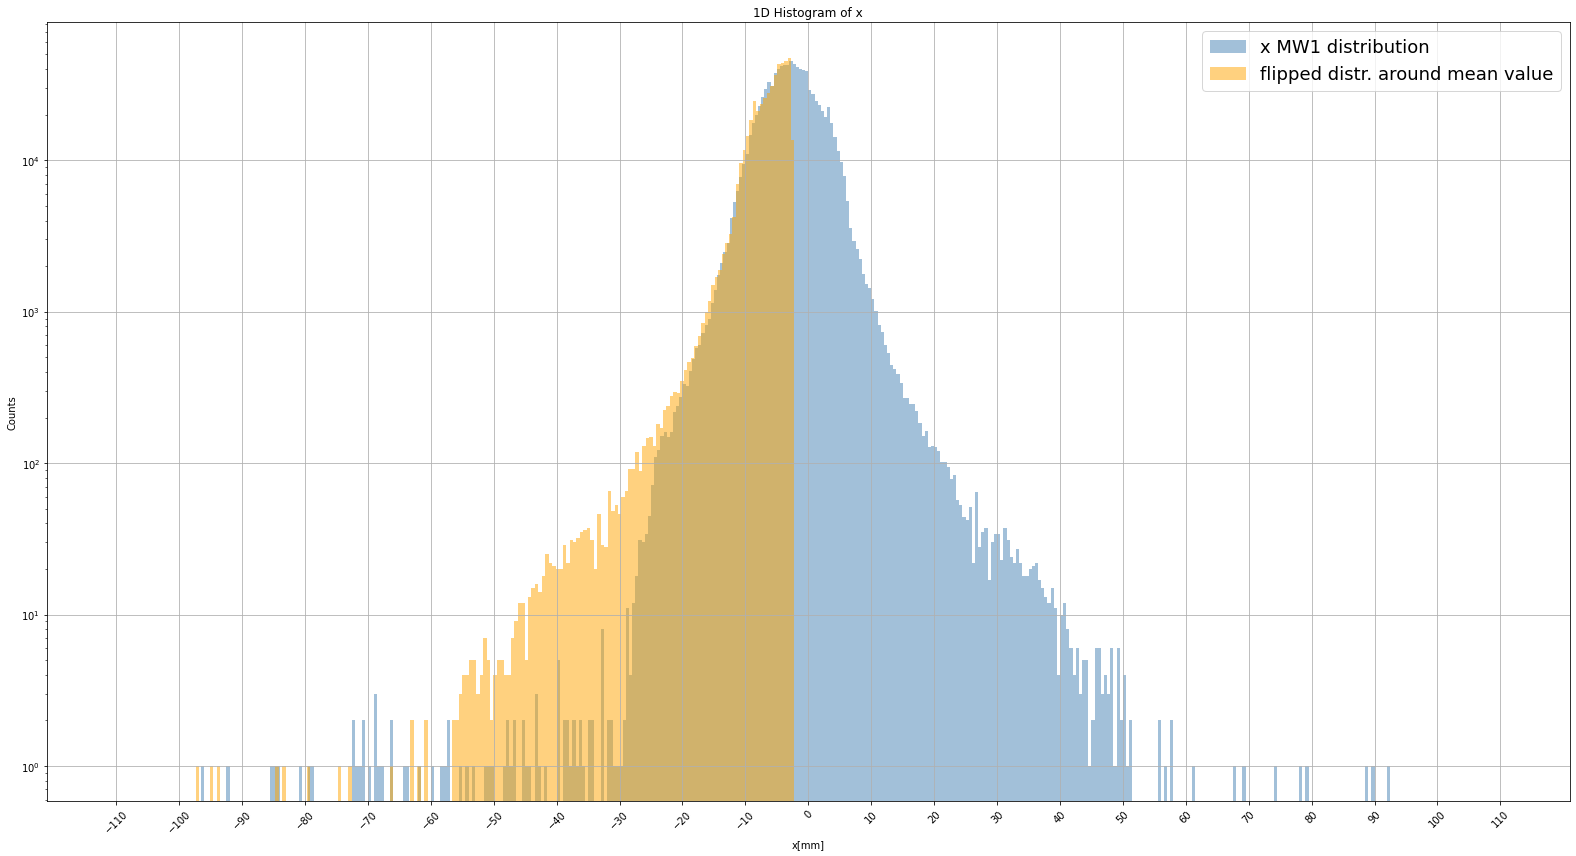

In [5]:
ticks = np.arange(-110, 110 + 0.5, 10)

plt.figure(figsize=(22, 12))
plt.hist(df["x"], bins=440, range=(-110, 110), color='steelblue',alpha=0.5,label="x MW1 distribution")
plt.hist(df["x_symmetric"].dropna(), bins=400, range=(-110, 110), color='orange',alpha=0.5,label="flipped distr. around mean value")
plt.xlabel("x[mm]")
plt.yscale("log")
plt.ylabel("Counts")
plt.title("1D Histogram of x")
plt.xticks(ticks, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=18)
#plt.show()
plt.savefig("mw1_x_distr_flipped.png",dpi=300)

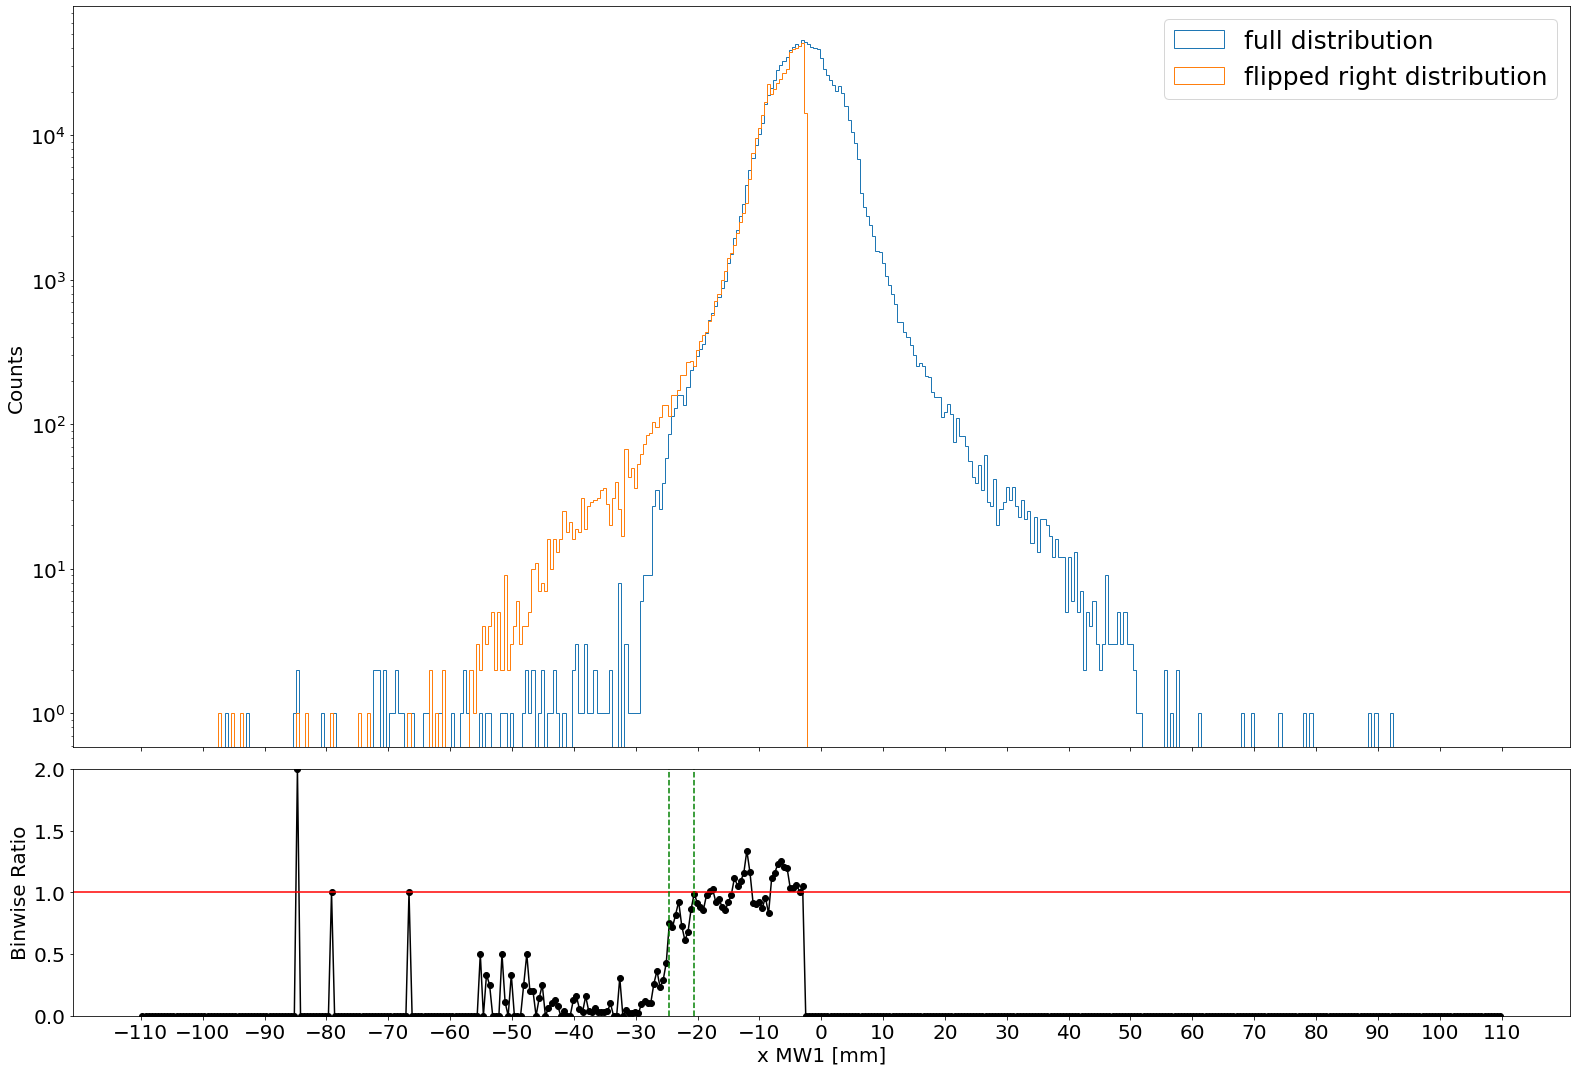

In [6]:
ticks = np.arange(-110, 110 + 0.5, 10)

# Define shared bins
bins = np.linspace(-110, 110, 440)

# Compute histograms for selected column
hist1, bin_edges = np.histogram(df['x'], bins=bins)
hist2, _ = np.histogram(df['x_symmetric'].dropna(), bins=bins)


nonzero_indices = np.nonzero(hist2)[0]
if len(nonzero_indices) > 0:
    last_nonzero_idx = nonzero_indices[-1]
    hist2[last_nonzero_idx] = 0 

# Compute bin centers
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])


#Calculate errror bars...
#hist1 = hist1.astype(float)
#hist2 = hist2.astype(float)

# Calculate ratio safely
with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.true_divide(hist1, hist2)
    ratio[~np.isfinite(ratio)] = 0  # Replace NaN, inf
arr_ratio = copy.deepcopy(ratio[ratio != 0])
#    # Error propagation
#    error = np.zeros_like(ratio)
#    mask = (hist1 > 0) & (hist2 > 0)
#    error[mask] = ratio[mask] * np.sqrt(1/hist1[mask] + 1/hist2[mask])
    
# Calculate ratio as histo
#with np.errstate(divide='ignore', invalid='ignore'):
#    ratio = np.true_divide(hist1, hist2)
#    # Set ratio to 0 where hist2 is 0
#    ratio[hist2 == 0] = 0
#
#    # Error propagation
#    error = np.zeros_like(ratio)
#    mask = (hist1 > 0) & (hist2 > 0)
#    error[mask] = ratio[mask] * np.sqrt(1/hist1[mask] + 1/hist2[mask])

    

# Plot
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               gridspec_kw={'height_ratios': [3, 1]},
                               figsize=(22, 15))

# Histogram plots
ax1.hist(df['x'], bins=bins, histtype='step', label='full distribution')
ax1.hist(df['x_symmetric'].dropna(), bins=bins, histtype='step', label='flipped right distribution')
ax1.legend(fontsize=18)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_yscale('log')
ax1.set_xticks(ticks)
ax1.tick_params(labelsize=20)

# Ratio plot

ax2.plot(bin_centers, ratio, marker='o', linestyle='solid', color='black') ## original one
#ax2.errorbar(bin_centers, ratio, yerr=error, fmt='o', label='Ratio with error bars',color='black')
#ax2.hist(ratio, bins=bins, edgecolor='black')
ax2.set_ylabel('Binwise Ratio',fontsize=20)
ax2.set_xlabel('x MW1 [mm]',fontsize=20)
ax2.set_ylim(0, 2)
ax2.set_xticks(ticks)
ax2.tick_params(labelsize=20)
ax2.axhline(y=1, color='r', linestyle='-')
ax2.axvline(x=-20.54669703, color='g', linestyle='--')
ax2.axvline(x=-24.555808, color='g', linestyle='--')

ax1.legend(fontsize=25)
plt.tight_layout()
plt.savefig("mw1_x_distr_flipped_and_bin_ratio_"+fname+".png",dpi=300)
plt.show()


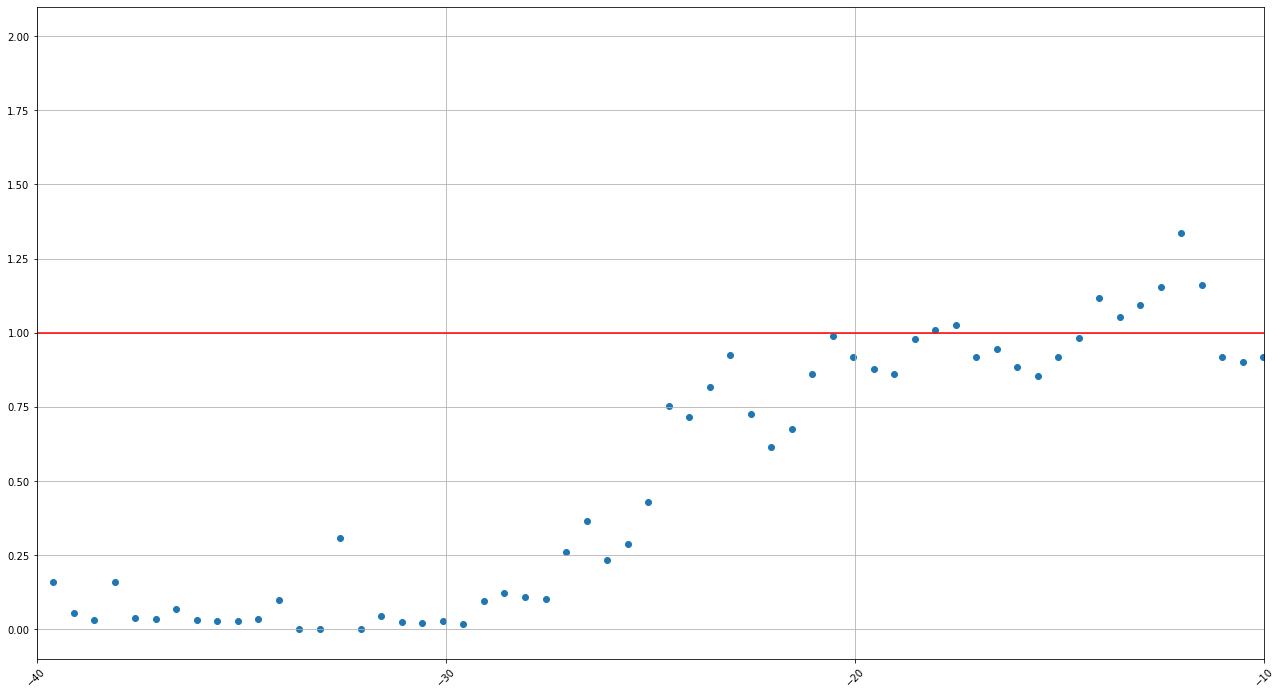

In [7]:
bins = np.linspace(-110, 110, 440)
#print(bins.shape)
#print(bins)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
plt.figure(figsize=(22, 12))
ticks = np.arange(-110, 110 + 0.5, 10)
plt.xticks(ticks, rotation=45)
#plt.bar(bin_centers,ratio,edgecolor="black") #original
plt.scatter(bin_centers,ratio)
plt.axhline(y=1, color='r', linestyle='-')
plt.xlim((-40,-10))
plt.grid()
plt.savefig("zoomed_binwise_ratio.png",dpi=300)

In [8]:
for i in range(len(ratio)):
    print("[",i,",",bin_centers[i],",",ratio[i],"]")


[ 0 , -109.749430523918 , 0.0 ]
[ 1 , -109.24829157175398 , 0.0 ]
[ 2 , -108.74715261958997 , 0.0 ]
[ 3 , -108.24601366742597 , 0.0 ]
[ 4 , -107.74487471526196 , 0.0 ]
[ 5 , -107.24373576309794 , 0.0 ]
[ 6 , -106.74259681093395 , 0.0 ]
[ 7 , -106.24145785876993 , 0.0 ]
[ 8 , -105.74031890660592 , 0.0 ]
[ 9 , -105.23917995444191 , 0.0 ]
[ 10 , -104.7380410022779 , 0.0 ]
[ 11 , -104.2369020501139 , 0.0 ]
[ 12 , -103.73576309794989 , 0.0 ]
[ 13 , -103.23462414578587 , 0.0 ]
[ 14 , -102.73348519362187 , 0.0 ]
[ 15 , -102.23234624145786 , 0.0 ]
[ 16 , -101.73120728929385 , 0.0 ]
[ 17 , -101.23006833712984 , 0.0 ]
[ 18 , -100.72892938496582 , 0.0 ]
[ 19 , -100.22779043280183 , 0.0 ]
[ 20 , -99.72665148063781 , 0.0 ]
[ 21 , -99.2255125284738 , 0.0 ]
[ 22 , -98.7243735763098 , 0.0 ]
[ 23 , -98.22323462414579 , 0.0 ]
[ 24 , -97.72209567198178 , 0.0 ]
[ 25 , -97.22095671981776 , 0.0 ]
[ 26 , -96.71981776765375 , 0.0 ]
[ 27 , -96.21867881548974 , 0.0 ]
[ 28 , -95.71753986332574 , 0.0 ]
[ 29 , -95

[ 300 , 40.592255125284765 , 0.0 ]
[ 301 , 41.093394077448764 , 0.0 ]
[ 302 , 41.59453302961276 , 0.0 ]
[ 303 , 42.095671981776775 , 0.0 ]
[ 304 , 42.59681093394079 , 0.0 ]
[ 305 , 43.0979498861048 , 0.0 ]
[ 306 , 43.59908883826881 , 0.0 ]
[ 307 , 44.100227790432825 , 0.0 ]
[ 308 , 44.60136674259684 , 0.0 ]
[ 309 , 45.102505694760836 , 0.0 ]
[ 310 , 45.603644646924835 , 0.0 ]
[ 311 , 46.10478359908885 , 0.0 ]
[ 312 , 46.60592255125286 , 0.0 ]
[ 313 , 47.10706150341687 , 0.0 ]
[ 314 , 47.608200455580885 , 0.0 ]
[ 315 , 48.1093394077449 , 0.0 ]
[ 316 , 48.61047835990891 , 0.0 ]
[ 317 , 49.11161731207291 , 0.0 ]
[ 318 , 49.61275626423691 , 0.0 ]
[ 319 , 50.11389521640092 , 0.0 ]
[ 320 , 50.61503416856493 , 0.0 ]
[ 321 , 51.116173120728945 , 0.0 ]
[ 322 , 51.61731207289296 , 0.0 ]
[ 323 , 52.11845102505697 , 0.0 ]
[ 324 , 52.61958997722098 , 0.0 ]
[ 325 , 53.120728929384995 , 0.0 ]
[ 326 , 53.621867881548994 , 0.0 ]
[ 327 , 54.12300683371299 , 0.0 ]
[ 328 , 54.624145785877005 , 0.0 ]
[ 329

In [9]:
## now calculate factor:
def corr_factor_finder(dframe,cut_val):
    integral_x = (dframe["x"] < cut_val).sum()
    integral_mirror = (dframe['x_symmetric'] < cut_val).sum()
    diff_integral = integral_mirror - integral_x
    corr_factor = 1+(float(diff_integral)/len(dframe["x"]))
    return diff_integral,corr_factor
    


print("MAXIMUM correction")
cut_val_max = -31.070615034168554 #-20.54669703872436      
diff_i,corr_f = corr_factor_finder(df,cut_val_max)
print(diff_i,corr_f)

print("MINIMUM correction")
cut_val_min = -32
diff_i,corr_f = corr_factor_finder(df,cut_val_min)
print(diff_i,corr_f)

MAXIMUM correction
720 1.0007422971209181
MINIMUM correction
637 1.000656726758368


In [10]:
arr_ratio[-40:-20].std()

0.12674232887000825

In [11]:
arr_ratio

array([2.        , 1.        , 1.        , 0.5       , 0.33333333,
       0.25      , 0.5       , 0.11111111, 0.33333333, 0.25      ,
       0.5       , 0.2       , 0.2       , 0.14285714, 0.25      ,
       0.0625    , 0.1       , 0.125     , 0.07692308, 0.04      ,
       0.125     , 0.15789474, 0.05555556, 0.03225806, 0.15789474,
       0.03703704, 0.03448276, 0.06666667, 0.03225806, 0.02857143,
       0.02777778, 0.03571429, 0.1       , 0.30769231, 0.04477612,
       0.02325581, 0.02      , 0.02777778, 0.01886792, 0.09677419,
       0.12328767, 0.10714286, 0.10344828, 0.25961538, 0.36458333,
       0.23214286, 0.28888889, 0.42962963, 0.75438596, 0.71698113,
       0.81761006, 0.92485549, 0.72727273, 0.61363636, 0.67657993,
       0.86181818, 0.98818898, 0.91692308, 0.87798408, 0.86091127,
       0.97940503, 1.00769231, 1.02447552, 0.91853933, 0.9436796 ,
       0.88461538, 0.85513608, 0.91830986, 0.98235294, 1.11737629,
       1.05283198, 1.0919586 , 1.15400552, 1.33686378, 1.16234

#### ok now I want to store things on text file
##### as mirror_mean,bin_left,bin_right, corr_min,corr_max

In [12]:
print(corr_factor_finder(df,cut_val_max))
print(corr_factor_finder(df,cut_val_min))
print(cut_val_min)
print(cut_val_max)
print(mean_val_mw1_x)
print(type(corr_factor_finder(df,cut_val_max)[1]))

(720, 1.0007422971209181)
(637, 1.000656726758368)
-32
-31.070615034168554
-2.595375769885992
<class 'float'>


In [13]:
with open("x_corr_vals_"+ fname + ".txt", "w") as f:
    f.write("%s,%s,%s,%s,%s" % (cut_val_min, corr_factor_finder(df, cut_val_min)[1],cut_val_max,corr_factor_finder(df,cut_val_max)[1],mean_val_mw1_x))